In [9]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random


In [15]:
#!pip install gym[box2d]
#!pip install gymnasium[box2d]
!pip install swig
!pip install box2d box2d-py
!pip install "gymnasium[box2d]"




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 71.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp312-cp312-linux_x86_64.whl size=2409541 sha256=7bfcc431826708e756999299c525d5a79b1ec3de2748f7cb7599adedfccbf412
  Stored in directory: /root/.cache/pip/wheels/d6/3c/ab/b6fd75459cadc56f4a4125d4cb387a708a59ca8589e4cc6b7d
Successfully built box2d-py
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done

  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409533 sha256=b5586522f32f5fe4bb322c16d79f3a3abf9661c53d77eb5f9b7a26be0f00e355
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.8
    Uninstalling box2d-py-

In [16]:
import gymnasium as gym

env = gym.make("BipedalWalker-v3")
state, info = env.reset()
print("State shape:", state.shape)


<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


State shape: (24,)


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [2]:
class LunarLanderDQN(nn.Module):
    def _init_(self, input_size, output_size):
        super(LunarLanderDQN, self)._init_()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.network(x)


In [3]:
class ReplayBuffer:
    def _init_(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def _len_(self):
        return len(self.buffer)

In [23]:
class LunarLanderAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.learning_rate = learning_rate

        # ε-greedy strategy
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Networks
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

        # Replay buffer
        self.memory = deque(maxlen=2000)

    def build_model(self):
        model = torch.nn.Sequential(
            torch.nn.Linear(self.state_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.action_size)
        )
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)   # explore
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()           # exploit

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=64):
        if len(self.memory) < batch_size:
            return None

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Q(s,a)
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()

        # Target Q
        next_q_values = self.target_model(next_states).max(1)[0]
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Loss
        loss = torch.nn.functional.mse_loss(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()


In [26]:
def train_lunar_lander(use_experience_replay=True, use_target_network=True):
    env = gym.make('LunarLander-v3')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = LunarLanderAgent(state_size, action_size)

    episodes = 1000
    scores = []
    epsilons = []
    losses = []
    update_target_every = 1000
    step_count = 0
    batch_size = 64 # Define batch_size

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Handle new gym API
        score = 0
        episode_loss = 0
        loss_count = 0
        done = False

        while not done:
            action = agent.act(state)
            result = env.step(action)
            if len(result) == 4:
                next_state, reward, done, _ = result
            else:
                next_state, reward, done, _, _ = result


            if use_experience_replay:
                agent.remember(state, action, reward, next_state, done)

            score += reward
            state = next_state
            step_count += 1

            if use_experience_replay and len(agent.memory) > batch_size: # Use batch_size here
                loss = agent.replay(batch_size) # Pass batch_size to replay
                episode_loss += loss
                loss_count += 1

            if use_target_network and step_count % update_target_every == 0:
                agent.update_target_model() # Correct method name

        if loss_count > 0:
            losses.append(episode_loss / loss_count)
        else:
            losses.append(0)


        scores.append(score)
        epsilons.append(agent.epsilon)

        if (episode + 1) % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {episode+1}, Average Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.3f}")

    env.close()
    return scores, epsilons, losses

Training with Experience Replay and Target Network...


/tmp/ipython-input-3499904690.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states)


Episode 100, Average Score: -724.91, Epsilon: 0.010
Episode 200, Average Score: -754.76, Epsilon: 0.010
Episode 300, Average Score: -741.82, Epsilon: 0.010
Episode 400, Average Score: -756.40, Epsilon: 0.010
Episode 500, Average Score: -828.08, Epsilon: 0.010
Episode 600, Average Score: -830.00, Epsilon: 0.010
Episode 700, Average Score: -725.58, Epsilon: 0.010
Episode 800, Average Score: -754.43, Epsilon: 0.010
Episode 900, Average Score: -732.20, Epsilon: 0.010
Episode 1000, Average Score: -686.66, Epsilon: 0.010

Training without Experience Replay and Target Network...
Episode 100, Average Score: -190.30, Epsilon: 1.000
Episode 200, Average Score: -176.67, Epsilon: 1.000
Episode 300, Average Score: -183.84, Epsilon: 1.000
Episode 400, Average Score: -173.46, Epsilon: 1.000
Episode 500, Average Score: -153.67, Epsilon: 1.000
Episode 600, Average Score: -181.54, Epsilon: 1.000
Episode 700, Average Score: -175.69, Epsilon: 1.000
Episode 800, Average Score: -177.19, Epsilon: 1.000
Episo

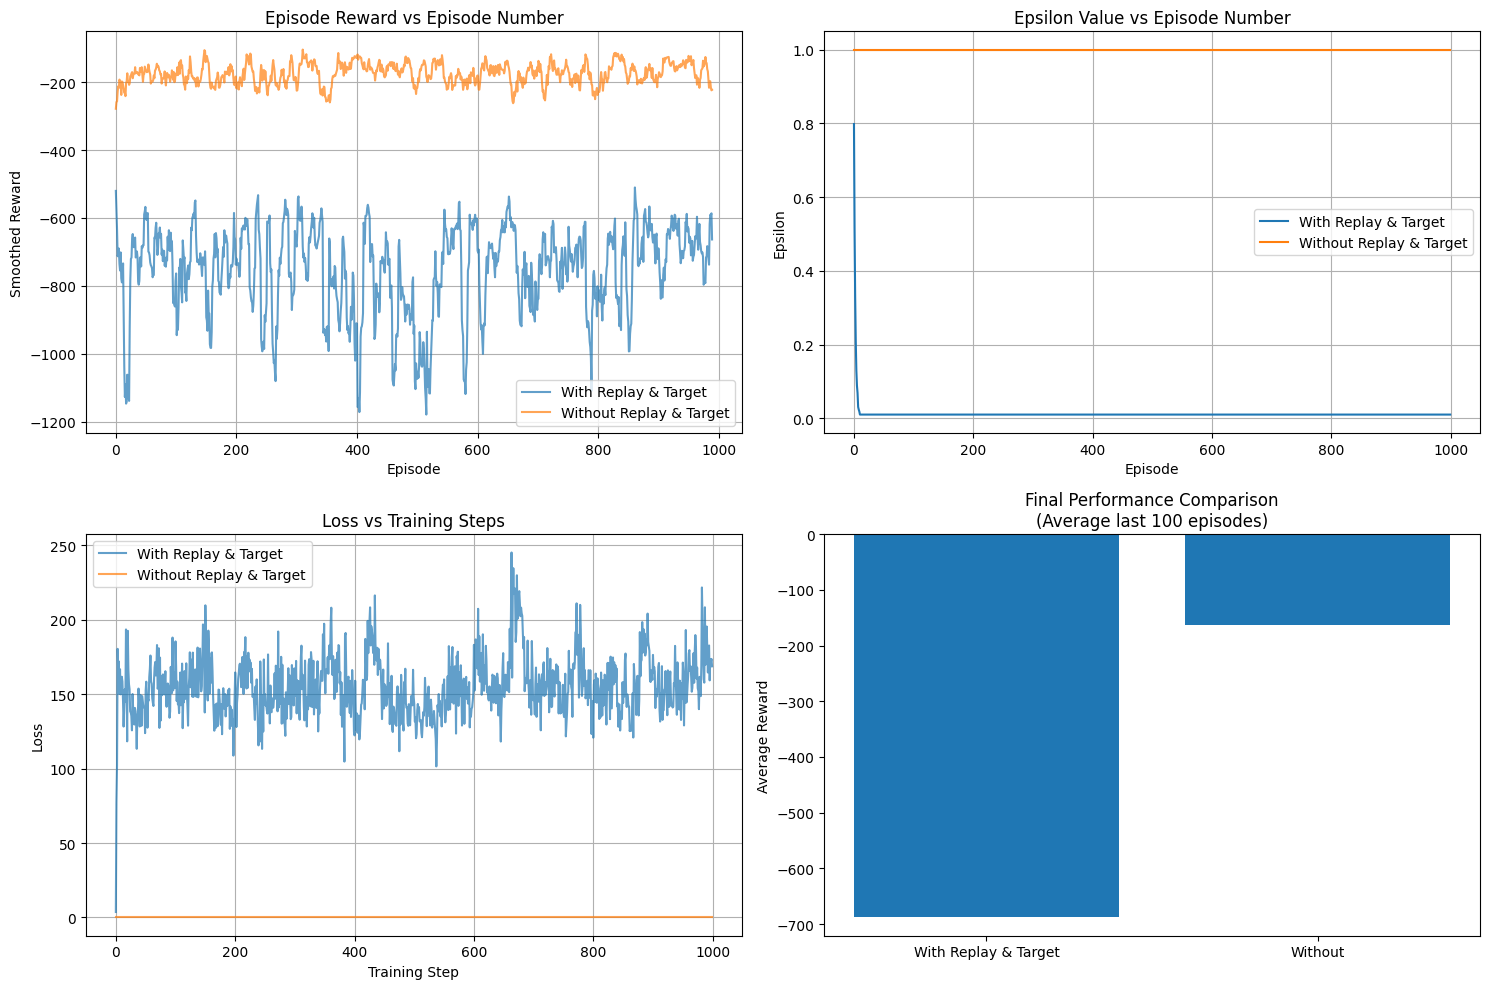


Performance Comparison Discussion:
With Experience Replay & Target Network:
  - Final 100-episode average: -686.66
  - More stable learning curve
  - Better convergence to optimal policy
  - Smoother loss reduction

Without Experience Replay & Target Network:
  - Final 100-episode average: -163.14
  - More unstable learning
  - Higher variance in rewards
  - May suffer from catastrophic forgetting


In [27]:


# Train with experience replay and target network
print("Training with Experience Replay and Target Network...")
scores_with, epsilons_with, losses_with = train_lunar_lander(use_experience_replay=True, use_target_network=True)

# Train without experience replay and target network for comparison
print("\nTraining without Experience Replay and Target Network...")
scores_without, epsilons_without, losses_without = train_lunar_lander(use_experience_replay=False, use_target_network=False)

# Plot results
plt.figure(figsize=(15, 10))

# Episode reward vs episode number
plt.subplot(2, 2, 1)
window = 10
smoothed_with = [np.mean(scores_with[i:i+window]) for i in range(len(scores_with)-window)]
smoothed_without = [np.mean(scores_without[i:i+window]) for i in range(len(scores_without)-window)]

plt.plot(smoothed_with, label='With Replay & Target', alpha=0.7)
plt.plot(smoothed_without, label='Without Replay & Target', alpha=0.7)
plt.title('Episode Reward vs Episode Number')
plt.xlabel('Episode')
plt.ylabel('Smoothed Reward')
plt.legend()
plt.grid(True)

# Epsilon value vs episode number
plt.subplot(2, 2, 2)
plt.plot(epsilons_with, label='With Replay & Target')
plt.plot(epsilons_without, label='Without Replay & Target')
plt.title('Epsilon Value vs Episode Number')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.legend()
plt.grid(True)

# Loss vs training steps
plt.subplot(2, 2, 3)
plt.plot(losses_with, label='With Replay & Target', alpha=0.7)
plt.plot(losses_without, label='Without Replay & Target', alpha=0.7)
plt.title('Loss vs Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Comparison of final performance
plt.subplot(2, 2, 4)
last_100_with = np.mean(scores_with[-100:])
last_100_without = np.mean(scores_without[-100:])
plt.bar(['With Replay & Target', 'Without'], [last_100_with, last_100_without])
plt.title('Final Performance Comparison\n(Average last 100 episodes)')
plt.ylabel('Average Reward')

plt.tight_layout()
plt.show()

# Performance discussion
print("\nPerformance Comparison Discussion:")
print(f"With Experience Replay & Target Network:")
print(f"  - Final 100-episode average: {last_100_with:.2f}")
print(f"  - More stable learning curve")
print(f"  - Better convergence to optimal policy")
print(f"  - Smoother loss reduction")

print(f"\nWithout Experience Replay & Target Network:")
print(f"  - Final 100-episode average: {last_100_without:.2f}")
print(f"  - More unstable learning")
print(f"  - Higher variance in rewards")
print(f"  - May suffer from catastrophic forgetting")